## Import Required Libraries

In [1]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.optimizers import Adam
from joblib import dump
import numpy as np
import matplotlib.pyplot as plt
import pickle
from flask import Flask, request, jsonify
import requests

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"


## Load the pre-trained model and add a classifier on top of the base model

In [2]:
model = Sequential([
    Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),
    Conv2D(256, (3, 3), activation="relu"),
    MaxPooling2D(2, 2)
    ])
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(80, activation="softmax"))



model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

## Define training parameters and callbacks

In [3]:
adam = Adam(learning_rate=0.003)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], run_eagerly=True)
bs = 100
train_dir = "../images/train/"
test_dir = "../images/test/"
train_datagen = ImageDataGenerator(rescale=1.0/255.)
test_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=bs, class_mode='categorical', target_size=(224, 224), shuffle=True)
validation_generator = test_datagen.flow_from_directory(test_dir, batch_size=bs, class_mode='categorical', target_size=(224, 224), shuffle=True)




Found 22566 images belonging to 80 classes.
Found 6505 images belonging to 80 classes.


## Fit Model

In [4]:
history = model.fit(train_generator,
                              steps_per_epoch=train_generator.samples // bs,
                              epochs=13,
                              validation_data=validation_generator,
                              validation_steps=validation_generator.samples // bs)

Epoch 1/13
225/225 [==============================] - 2587s 11s/step - loss: 3.8543 - accuracy: 0.1092 - val_loss: 4.1102 - val_accuracy: 0.0588
Epoch 2/13
225/225 [==============================] - 2932s 13s/step - loss: 3.5456 - accuracy: 0.1584 - val_loss: 3.7749 - val_accuracy: 0.1243
Epoch 3/13
225/225 [==============================] - 2416s 11s/step - loss: 3.3118 - accuracy: 0.2001 - val_loss: 3.7084 - val_accuracy: 0.1434
Epoch 4/13
225/225 [==============================] - 1957s 9s/step - loss: 3.1212 - accuracy: 0.2338 - val_loss: 3.5839 - val_accuracy: 0.1738
Epoch 5/13
225/225 [==============================] - 2339s 10s/step - loss: 2.9246 - accuracy: 0.2655 - val_loss: 3.4057 - val_accuracy: 0.1868
Epoch 6/13
225/225 [==============================] - 1791s 8s/step - loss: 2.7234 - accuracy: 0.3048 - val_loss: 3.4092 - val_accuracy: 0.1962
Epoch 7/13
225/225 [==============================] - 1825s 8s/step - loss: 2.5191 - accuracy: 0.3456 - val_loss: 3.2120 - val_accur

## Save model

In [5]:
model.save('./Animals_prediction_model.h5')
weights = model.get_weights()
dump(weights, './Animals_prediction_model.joblib')
with open('./Animals_prediction_model.pkl', 'wb') as f:
    pickle.dump(weights, f)

## Evaluate the model

66/66 [==============================] - 604s 9s/step - loss: 4.4828 - accuracy: 0.2028
Test loss: 4.482806205749512
Test accuracy: 0.20276710391044617


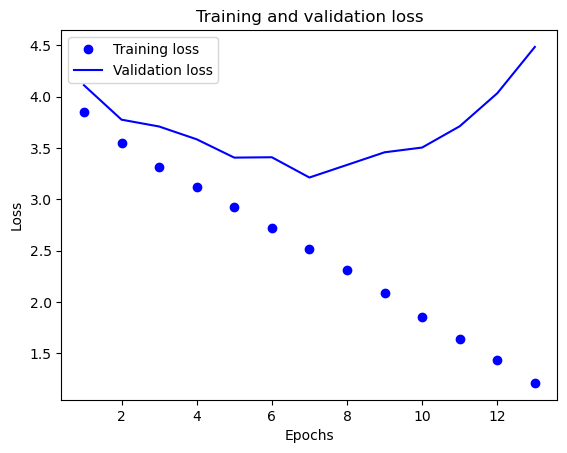

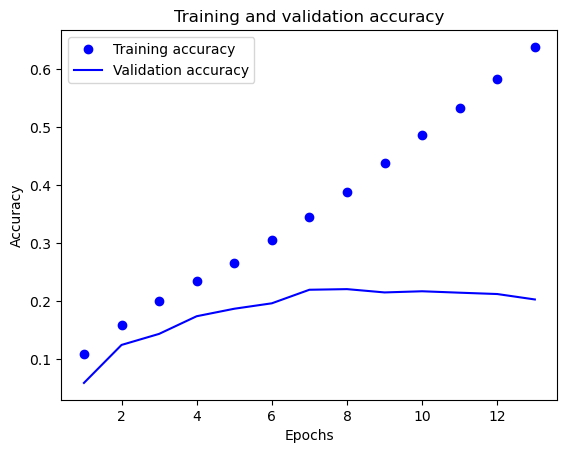

In [6]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(validation_generator)

# Print the test loss and accuracy
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Test prediction

In [13]:
import requests

# Define the Flask application endpoint URL
url = "http://localhost:5050/predict"

# Load the image file as bytes
with open("./predict/3.jpg", "rb") as image_file:
    image_data = image_file.read()

# Send a POST request to the Flask application with the image file
response = requests.post(url, files={"file": image_data})

# Parse the response to get the predicted animal category
if response.status_code == 200:
    result = response.json()
    prediction = result["prediction"]
    print(f"The predicted animal category is: {prediction}")
else:
    print("Error: Failed to get prediction from Flask application.")

The predicted animal category is: [[1.29878375e-08 1.18695509e-09 8.85923335e-09 5.79397893e-04
  1.86652898e-07 6.67215930e-03 2.57718988e-04 1.79429344e-06
  9.65804929e-07 2.34968613e-08 2.36000687e-05 1.38999405e-03
  4.09087224e-05 7.30897737e-05 5.25916973e-03 1.60249518e-04
  4.00822870e-07 8.85085821e-01 2.12625673e-05 7.94882217e-05
  1.29066801e-04 3.64984004e-07 9.59635247e-03 1.53476710e-03
  2.97233078e-06 2.57822439e-08 1.25548583e-09 2.76776753e-08
  9.44353360e-06 4.86124163e-09 2.00959598e-03 6.37284714e-08
  3.02413468e-06 3.31934687e-04 6.53321131e-09 7.15983006e-08
  5.72033413e-02 3.08058816e-06 1.41693008e-05 8.96394253e-04
  3.01827299e-07 2.25943331e-05 3.95231439e-08 5.55204679e-07
  9.90952529e-08 2.60740379e-03 7.09170024e-07 2.93705356e-03
  9.00243002e-04 3.31237561e-06 3.16079204e-05 1.17762795e-06
  3.09960448e-08 4.40950644e-05 2.92142062e-07 1.94620533e-08
  5.55824772e-06 4.25294679e-08 3.59883672e-03 6.37361081e-05
  1.78919220e-03 1.63342236e-04 1.78